# ECG-ViEW II Data Processing

From our paper on "Explainable Prediction of Acute Myocardial Infarction using Machine Learning and Shapley Values"

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pylab as plt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib histogram bins
bin_size = 40

## 1. ECG Data Processing

In [2]:
df_ECG = pd.read_csv('Electrocardiogram.csv')
df_ECG.head()

,personid,ecgdate,ecgdept,ecgsource,RR,PR,QRS,QT,QTc,P_wave_axis,QRS_axis,T_wave_axis,ACCI
0,120971,2006-05-23 09:57:00,H,M,952.0,NaN,NaN,388,397,NaN,NaN,NaN,9
1,120971,2012-04-19 08:09:06,H,E,750.0,140.0,84.0,360,415,NaN,NaN,NaN,9
2,270,2004-07-03 09:05:13,O,M,600.0,122.0,78.0,318,410,62.0,86.0,61.0,7
3,306709,2013-04-06 22:10:16,E,M,577.0,150.0,92.0,362,476,17.0,46.0,70.0,12
4,87768,1997-12-17 11:11:26,O,M,698.0,136.0,88.0,354,423,28.0,59.0,29.0,3


In [3]:
df_ECG.shape

(979273, 13)

In [4]:
df_ECG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979273 entries, 0 to 979272
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   personid     979273 non-null  int64  
 1   ecgdate      979273 non-null  object 
 2   ecgdept      979273 non-null  object 
 3   ecgsource    979273 non-null  object 
 4   RR           979239 non-null  float64
 5   PR           774260 non-null  float64
 6   QRS          810373 non-null  float64
 7   QT           979273 non-null  int64  
 8   QTc          979273 non-null  int64  
 9   P_wave_axis  732827 non-null  float64
 10  QRS_axis     762274 non-null  float64
 11  T_wave_axis  762248 non-null  float64
 12  ACCI         979273 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 97.1+ MB


In [5]:
df_ECG.describe()

,personid,RR,PR,QRS,QT,QTc,P_wave_axis,QRS_axis,T_wave_axis,ACCI
count,979273.000000,979239.000000,774260.000000,810373.000000,979273.000000,979273.000000,732827.000000,762274.000000,762248.000000,979273.000000
mean,231021.688946,851.683240,157.081364,91.061474,389.997336,425.415081,48.357848,45.215670,46.198097,7.580933
std,133238.981417,196.989159,26.661289,15.149489,43.490019,31.493654,24.848064,38.048566,38.416339,3.062956
min,1.000000,204.000000,36.000000,2.000000,70.000000,53.000000,-89.000000,-89.000000,-89.000000,0.000000
25%,115711.000000,732.000000,140.000000,82.000000,364.000000,405.000000,36.000000,22.000000,28.000000,6.000000
50%,231037.000000,857.000000,156.000000,88.000000,390.000000,420.000000,52.000000,51.000000,44.000000,8.000000
75%,346411.000000,968.000000,172.000000,98.000000,416.000000,440.000000,65.000000,71.000000,59.000000,10.000000
max,461795.000000,30000.000000,1738.000000,380.000000,852.000000,878.000000,270.000000,270.000000,270.000000,23.000000


In [6]:
df_ECG.isnull().sum()

personid            0
ecgdate             0
ecgdept             0
ecgsource           0
RR                 34
PR             205013
QRS            168900
QT                  0
QTc                 0
P_wave_axis    246446
QRS_axis       216999
T_wave_axis    217025
ACCI                0
dtype: int64

In [7]:
# Drop instances that have missing values 
df_ECG_full = df_ECG.dropna(subset=['RR', 'PR', 'QRS', 'P_wave_axis','QRS_axis', 'T_wave_axis']);

In [8]:
df_ECG_full.isnull().sum()

personid       0
ecgdate        0
ecgdept        0
ecgsource      0
RR             0
PR             0
QRS            0
QT             0
QTc            0
P_wave_axis    0
QRS_axis       0
T_wave_axis    0
ACCI           0
dtype: int64

In [9]:
df_ECG_full.shape

(726444, 13)

In [10]:
# Drop unrelevant information 
df_ECG_full = df_ECG_full.drop(columns = ['ecgdate', 'ecgsource', 'ecgdept'])

In [11]:
df_ECG_full.head()

,personid,RR,PR,QRS,QT,QTc,P_wave_axis,QRS_axis,T_wave_axis,ACCI
2,270,600.0,122.0,78.0,318,410,62.0,86.0,61.0,7
3,306709,577.0,150.0,92.0,362,476,17.0,46.0,70.0,12
4,87768,698.0,136.0,88.0,354,423,28.0,59.0,29.0,3
5,209545,638.0,112.0,94.0,368,460,14.0,132.0,-3.0,6
8,269001,741.0,136.0,84.0,362,420,65.0,42.0,31.0,7


In [12]:
df_ECG_full['personid'].value_counts();

## 2. Diagnosis Code + Personal Info (Sex)

In [13]:
df_diag = pd.read_csv('Diagnosis.csv', encoding='latin-1')
df_diag.head()

,personid,diagdate,diagcode,diagdept
0,141778,1997-06-04 00:00:00,otherdiagnosis,O
1,141778,1997-06-07 00:00:00,otherdiagnosis,O
2,141778,1997-06-16 00:00:00,otherdiagnosis,O
3,141778,1997-06-23 00:00:00,otherdiagnosis,O
4,141778,1997-06-30 00:00:00,otherdiagnosis,O


In [14]:
df_diag.shape

(7743772, 4)

In [15]:
# Drop duplicate entries (repeated entry of the same ID)
df_diag_two = df_diag.sort_values('diagdate').drop_duplicates('personid',keep='last')
df_diag_two.sort_values(by=['personid']);

In [16]:
df_diag_two['personid'].value_counts();

In [17]:
df_diag_two.shape

(424363, 4)

In [18]:
df_person = pd.read_csv('Person.csv')
df_person.head()

,personid,sex,Birthyeargroup,ethnicity
0,369485,1,16,1
1,138392,0,14,1
2,188469,1,20,1
3,169164,0,12,1
4,434516,1,14,1


In [19]:
df_person.shape

(461034, 4)

In [20]:
# Merge the diagnosis dataset with the personal info dataset with the common column (personid)
df_diag_person = pd.merge(df_diag_two, df_person, on='personid')

In [21]:
df_diag_person.head()

,personid,diagdate,diagcode,diagdept,sex,Birthyeargroup,ethnicity
0,68536,1994-08-30 02:37:00,otherdiagnosis,I,1,16,1
1,216182,1995-01-03 23:45:00,otherdiagnosis,I,1,4,1
2,458392,1995-01-04 16:27:00,otherdiagnosis,I,1,10,1
3,396139,1995-01-06 15:19:00,otherdiagnosis,I,0,7,1
4,251126,1995-01-12 17:33:00,otherdiagnosis,I,0,11,1


In [22]:
df_diag_person.shape

(424363, 7)

In [23]:
df_diag_person.isnull().sum()

personid          0
diagdate          0
diagcode          0
diagdept          0
sex               0
Birthyeargroup    0
ethnicity         0
dtype: int64

In [24]:
####################### Create a new feature base on the diagnosis code: MI (1 = MI, 0 = no) ################

# To select rows whose column value is in list 
code = ['I20','I25']
condition = df_diag_person.diagcode.isin(code)

df_diag_person['MI'] = np.where(condition, '1', '0')
df_diag_person.head()

,personid,diagdate,diagcode,diagdept,sex,Birthyeargroup,ethnicity,MI
0,68536,1994-08-30 02:37:00,otherdiagnosis,I,1,16,1,0
1,216182,1995-01-03 23:45:00,otherdiagnosis,I,1,4,1,0
2,458392,1995-01-04 16:27:00,otherdiagnosis,I,1,10,1,0
3,396139,1995-01-06 15:19:00,otherdiagnosis,I,0,7,1,0
4,251126,1995-01-12 17:33:00,otherdiagnosis,I,0,11,1,0


In [25]:
df_diag_person.shape

(424363, 8)

In [26]:
# Check the number of entries of a specific diagnostic code 
df_diag_person['diagcode'][df_diag_person['diagcode'] == "I20"].value_counts()

I20    4358
Name: diagcode, dtype: int64

In [27]:
df_diag_person['diagcode'].value_counts();

In [28]:
df_diag_person['MI'].value_counts()

0    418200
1      6163
Name: MI, dtype: int64

<AxesSubplot:title={'center':'MI Count'}>

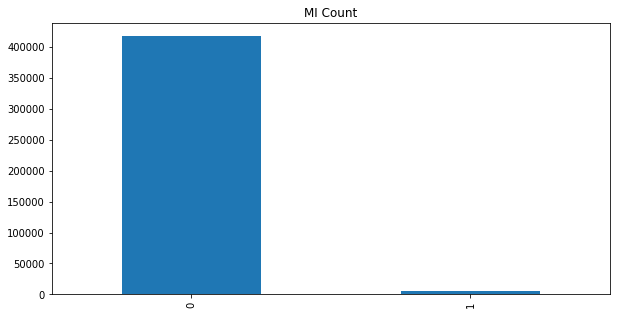

In [29]:
df_diag_person['MI'].value_counts().plot(kind='bar', title='MI Count')

In [30]:
df_diag_person.head()

,personid,diagdate,diagcode,diagdept,sex,Birthyeargroup,ethnicity,MI
0,68536,1994-08-30 02:37:00,otherdiagnosis,I,1,16,1,0
1,216182,1995-01-03 23:45:00,otherdiagnosis,I,1,4,1,0
2,458392,1995-01-04 16:27:00,otherdiagnosis,I,1,10,1,0
3,396139,1995-01-06 15:19:00,otherdiagnosis,I,0,7,1,0
4,251126,1995-01-12 17:33:00,otherdiagnosis,I,0,11,1,0


## 3. Merge To Obtain The Final Dataset 

In [31]:
# Merge the ecg dataset with the combined diagnosis/personal info dataset using the common column (personid)
df_1 = pd.merge(df_ECG_full, df_diag_person, on='personid')
df_1.head()

,personid,RR,PR,QRS,QT,QTc,P_wave_axis,QRS_axis,T_wave_axis,ACCI,diagdate,diagcode,diagdept,sex,Birthyeargroup,ethnicity,MI
0,270,600.0,122.0,78.0,318,410,62.0,86.0,61.0,7,2004-07-19 00:00:00,otherdiagnosis,O,1,21,1,0
1,270,594.0,124.0,78.0,306,396,67.0,85.0,60.0,7,2004-07-19 00:00:00,otherdiagnosis,O,1,21,1,0
2,306709,577.0,150.0,92.0,362,476,17.0,46.0,70.0,12,2013-06-16 17:15:00,I10,I,0,7,1,0
3,306709,645.0,162.0,90.0,372,462,99.0,55.0,82.0,11,2013-06-16 17:15:00,I10,I,0,7,1,0
4,306709,638.0,200.0,94.0,378,472,17.0,67.0,84.0,12,2013-06-16 17:15:00,I10,I,0,7,1,0


In [32]:
df_1.shape

(713447, 17)

In [33]:
df_2 = df_1.drop(columns = ['diagdate', 'diagcode', 'diagdept', 'personid', 'ethnicity'])
col_names = df_2.columns
df_2.head()

,RR,PR,QRS,QT,QTc,P_wave_axis,QRS_axis,T_wave_axis,ACCI,sex,Birthyeargroup,MI
0,600.0,122.0,78.0,318,410,62.0,86.0,61.0,7,1,21,0
1,594.0,124.0,78.0,306,396,67.0,85.0,60.0,7,1,21,0
2,577.0,150.0,92.0,362,476,17.0,46.0,70.0,12,0,7,0
3,645.0,162.0,90.0,372,462,99.0,55.0,82.0,11,0,7,0
4,638.0,200.0,94.0,378,472,17.0,67.0,84.0,12,0,7,0


In [34]:
df_2['Birthyeargroup'].value_counts();

In [35]:
df_2.shape

(713447, 12)

In [36]:
df_2['MI'].value_counts()

0    688837
1     24610
Name: MI, dtype: int64

<AxesSubplot:title={'center':'MI Count'}>

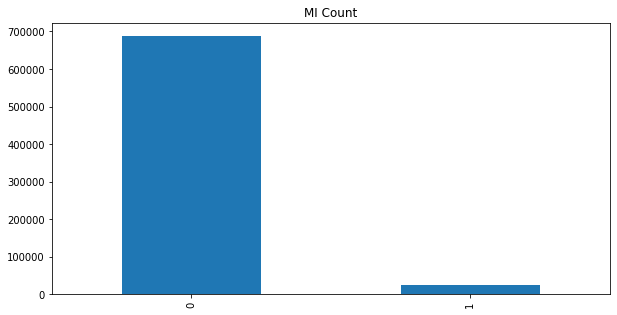

In [37]:
df_2['MI'].value_counts().plot(kind='bar', title='MI Count')

## 4. Robust Scaling & SMOTE 

In [38]:
# Get training data from dataframe
train_data = df_2.values

In [39]:
# Defining the scaler
robust_scaler = RobustScaler().fit(train_data)

# Scaling test data using robust scaling
train_data_robust = robust_scaler.transform(train_data)

# Training data features
train_features_robust= train_data_robust[:, 0:11]

# 'MI' column values
train_target_robust = train_data_robust[:, 11]

In [40]:
# Minority oversampling using SMOTE
over = SMOTE(sampling_strategy=0.25) 
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_resampled, y_resampled = pipeline.fit_resample(train_features_robust, train_target_robust)

In [41]:
# Split 80-20 train vs test data
x_train, x_test, y_train, y_test = train_test_split(x_resampled, 
                                                    y_resampled, 
                                                    test_size=0.20, 
                                                    random_state=0,
                                                    shuffle=True)

## 5. Exporting Data As CSV

In [42]:
# Export train data
df_train=pd.DataFrame(data=x_train)
df_train.insert(11, column= 'labels', value=y_train)
df_train.to_csv('train.csv', index=False, header=False)

# Export test data
df_train=pd.DataFrame(data=x_test)
df_train.insert(11, column= 'labels', value=y_test)
df_train.to_csv('test.csv', index=False, header=False)